In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import os
import datetime
import time
from collections import defaultdict
import multiprocessing
from concurrent.futures import ProcessPoolExecutor
import sys
from pathlib import Path

# For model conversion
from tensorflow.python.framework import graph_util
from tensorflow.python.framework import graph_io
from tensorflow.keras import backend as K

In [24]:
def load_events(file, max_events=None):
    """Load DVS events from a text file or uploaded file object with optimized batch parsing."""
    import io

    if isinstance(file, str):
        # File path from disk
        with open(file, 'r') as f:
            lines = f.readlines()
    elif isinstance(file, io.BytesIO):
        # Uploaded file from Colab
        lines = file.read().decode('utf-8').splitlines()
    else:
        raise ValueError("Unsupported file type")

    # Skip header
    start_idx = 0
    for i, line in enumerate(lines):
        if line.startswith('#'):
            start_idx = i + 1
        else:
            break

    # Process lines in batches
    batch_size = 10000
    total_events = len(lines) - start_idx
    if max_events is not None:
        total_events = min(total_events, max_events)

    events = []
    for i in range(0, total_events, batch_size):
        end_idx = min(i + batch_size, total_events)
        batch_lines = lines[start_idx + i : start_idx + end_idx]

        for line in batch_lines:
            try:
                t, x, y, p = line.strip().split()
                events.append((float(t), int(x), int(y), int(p)))
            except ValueError:
                continue

    print(f"✅ Loaded {len(events)} events")
    return np.array(events, dtype=[('t', np.float32), ('x', np.int16), ('y', np.int16), ('p', np.int8)])


In [30]:
def load_events_from_csv(file, max_events=None, cols=None, has_header=True):
    """
    Load DVS events from a CSV file with flexible column mapping.

    Args:
        file: Path to CSV file (can be Google Drive path)
        max_events: Maximum number of events to load (None for all)
        cols: List of column indices [t_col, x_col, y_col, p_col] or None to use default mappings
        has_header: Whether the CSV has a header row

    Returns:
        Structured numpy array of events (t, x, y, p)
    """
    try:
        # Ensure file exists
        if not os.path.exists(file):
            raise FileNotFoundError(f"File not found: {file}")

        # Read CSV file
        if has_header:
            df = pd.read_csv(file)
        else:
            df = pd.read_csv(file, header=None)

        # Display first few rows to understand the data
        print(f"Preview of data from {file}:")
        print(df.head())

        # If columns not specified, try to determine them
        if cols is None:
            # If columns have standard names
            if all(col in df.columns for col in ['t', 'x', 'y', 'p']):
                t_col, x_col, y_col, p_col = 't', 'x', 'y', 'p'
            # If columns are named with letters (A, B, C...)
            elif all(col in df.columns for col in ['A', 'B', 'C', 'D']):
                t_col, x_col, y_col, p_col = 'A', 'B', 'C', 'D'
            # Otherwise use first four columns
            else:
                t_col = df.columns[0]
                x_col = df.columns[1]
                y_col = df.columns[2]
                p_col = df.columns[3]
                print(f"Using columns {t_col}, {x_col}, {y_col}, {p_col} for t, x, y, p")
        else:
            # Use provided column indices
            t_col, x_col, y_col, p_col = [df.columns[i] for i in cols]

        # Limit events if needed
        if max_events is not None:
            df = df.head(max_events)

        # Check range of values to determine appropriate data types
        t_min, t_max = df[t_col].min(), df[t_col].max()
        x_min, x_max = df[x_col].min(), df[x_col].max()
        y_min, y_max = df[y_col].min(), df[y_col].max()
        p_min, p_max = df[p_col].min(), df[p_col].max()

        print(f"Value ranges:")
        print(f"  t: {t_min} to {t_max}")
        print(f"  x: {x_min} to {x_max}")
        print(f"  y: {y_min} to {y_max}")
        print(f"  p: {p_min} to {p_max}")

        # Choose appropriate data types based on values
        t_type = np.float64  # Use float64 for timestamps
        x_type = np.int32 if x_max > 32767 or x_min < -32768 else np.int16
        y_type = np.int32 if y_max > 32767 or y_min < -32768 else np.int16
        p_type = np.int32 if p_max > 127 or p_min < -128 else np.int8

        # Extract events with appropriate types
        events = np.array(list(zip(
            df[t_col].astype(float),
            df[x_col].astype(int),
            df[y_col].astype(int),
            df[p_col].astype(int)
        )), dtype=[('t', t_type), ('x', x_type), ('y', y_type), ('p', p_type)])

        print(f"✅ Loaded {len(events)} events from CSV with data types: t={t_type}, x={x_type}, y={y_type}, p={p_type}")
        return events

    except Exception as e:
        print(f"❌ Error loading CSV: {str(e)}")
        raise

In [32]:
def save_events_to_csv(events, output_file, include_header=True):
    """
    Save DVS events to a CSV file with standard column names.

    Args:
        events: Structured numpy array of events (t, x, y, p)
        output_file: Path to save CSV file (can be Google Drive path)
        include_header: Whether to include a header row
    """
    try:
        # Create directory if it doesn't exist
        output_dir = os.path.dirname(output_file)
        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir, exist_ok=True)

        # Convert structured array to DataFrame with standard column names
        df = pd.DataFrame({
            't': events['t'],
            'x': events['x'],
            'y': events['y'],
            'p': events['p']
        })

        # Save to CSV
        df.to_csv(output_file, index=False, header=include_header)
        print(f"✅ Saved {len(events)} events to {output_file}")

    except Exception as e:
        print(f"❌ Error saving CSV: {str(e)}")
        raise

def convert_txt_to_csv(txt_file, csv_file, has_header=False):
    """
    Convert space-delimited text event file to CSV format with standard column names.

    Args:
        txt_file: Path to input text file
        csv_file: Path to output CSV file
        has_header: Whether text file has a header row to preserve
    """
    try:
        # Load events from text file
        events = load_events(txt_file)

        # Save to CSV with standard column names
        save_events_to_csv(events, csv_file, include_header=True)
        print(f"✅ Converted {txt_file} to {csv_file}")

    except Exception as e:
        print(f"❌ Error converting file: {str(e)}")
        raise

In [33]:
# Load files from Google Drive
import os

# Ask for file format
file_format = input("Enter file format (txt or csv): ").lower()
is_csv = file_format == "csv"

# Get file paths from Google Drive
print("Enter the path to your files in Google Drive:")
print("Example: /content/drive/MyDrive/DVSTraining")
base_path = input("Base path: ")

# Get filenames
print("Enter the filenames (relative to the base path):")
noisy_filename = input("Noisy events filename: ")
clean_filename = input("Clean events filename: ")

# Construct full paths
noisy_file = os.path.join(base_path, noisy_filename)
clean_file = os.path.join(base_path, clean_filename)

# Verify files exist
if not os.path.exists(noisy_file):
    raise FileNotFoundError(f"File not found: {noisy_file}")
if not os.path.exists(clean_file):
    raise FileNotFoundError(f"File not found: {clean_file}")

print(f"Loading files:\n  - {noisy_file}\n  - {clean_file}")

# Load event data using the appropriate function
if is_csv:
    # For CSV files, we need to determine which columns to use (first 4 columns)
    noisy_events = load_events_from_csv(noisy_file, cols=[0, 1, 2, 3])
    clean_events = load_events_from_csv(clean_file, cols=[0, 1, 2, 3])
else:
    noisy_events = load_events(noisy_file)
    clean_events = load_events(clean_file)

print(f"Loaded {len(noisy_events)} noisy events and {len(clean_events)} clean events")

Enter file format (txt or csv): csv
Enter the path to your files in Google Drive:
Example: /content/drive/MyDrive/DVSTraining
Base path: /content/drive/MyDrive/DVSTraining
Enter the filenames (relative to the base path):
Noisy events filename: mixedhotellightTI25.csv
Clean events filename: amixedhotellightTI25.csv
Loading files:
  - /content/drive/MyDrive/DVSTraining/mixedhotellightTI25.csv
  - /content/drive/MyDrive/DVSTraining/amixedhotellightTI25.csv
Preview of data from /content/drive/MyDrive/DVSTraining/mixedhotellightTI25.csv:
   -1   60  131  1610903445  1  2090596  5096365  2089490  2120375  2079095  \
0   1  181  158  1610903470  1  2120900  5579979  3438179  3001284  5335559   
1   1  172  159  1610903475  1  2114237  5246538  5104601  3884158        0   
2  -1  189  154  1610903489  1  2081398  5158468        0  2138209  5492236   
3   1  165  159  1610903505  1        0  4325362        0  3118796  5078815   
4   1  185  132  1610903509  1        0  2874090  4775733  2123682

In [5]:
# define this function at the module level, outside any other function
def process_chunk(chunk, height, width):
    local_ti = np.zeros((height, width), dtype=np.float32)
    local_pol = np.zeros((height, width), dtype=np.float32)

    for t, x, y, p in chunk:
        if 0 <= x < width and 0 <= y < height:
            local_ti[y, x] = t
            local_pol[y, x] = 1 if p == 1 else -1

    return local_ti, local_pol

# Then modify the function to use the global function
def build_timestamp_image_parallel(events, width=346, height=260, num_workers=None):
    """Build a timestamp image with parallel processing for large datasets."""
    if num_workers is None:
        num_workers = max(1, multiprocessing.cpu_count() - 1)

    # Initialize timestamp image with zeros
    ti = np.zeros((height, width), dtype=np.float32)
    polarity_img = np.zeros((height, width), dtype=np.float32)

    # Create chunks of events for parallel processing
    chunk_size = max(1000, len(events) // (num_workers * 10))
    chunks = [events[i:i+chunk_size] for i in range(0, len(events), chunk_size)]

    # Process chunks in parallel
    if num_workers > 1 and len(chunks) > 1:
        # Pass height and width to the function using partial
        from functools import partial
        process_func = partial(process_chunk, height=height, width=width)

        with ProcessPoolExecutor(max_workers=num_workers) as executor:
            results = list(executor.map(process_func, chunks))

        # Merge results - take the most recent timestamp for each pixel
        for local_ti, local_pol in results:
            # Update main TI with newer timestamps
            mask = (local_ti > 0) & ((ti == 0) | (local_ti > ti))
            ti[mask] = local_ti[mask]
            polarity_img[mask] = local_pol[mask]
    else:
        # For small datasets, just process sequentially
        for t, x, y, p in events:
            if 0 <= x < width and 0 <= y < height:
                ti[y, x] = t
                polarity_img[y, x] = 1 if p == 1 else -1

    return ti, polarity_img

In [6]:
def match_events(noisy_events, clean_events, tau=0.1, spatial_threshold=1):
    """
    Match noisy events to clean events using spatiotemporal correlation as described in the paper.

    Args:
        noisy_events: Array of noisy events (t, x, y, p)
        clean_events: Array of clean events (t, x, y, p)
        tau: Time correlation window (in seconds)
        spatial_threshold: Maximum spatial distance to consider a match

    Returns:
        Numpy array of labels (1 for signal, 0 for noise)
    """
    # Build a spatial index for clean events
    clean_event_dict = defaultdict(list)
    for i, (t, x, y, p) in enumerate(clean_events):
        # Store events by their spatial location
        clean_event_dict[(x, y)].append((t, p, i))

    # Create labels array
    labels = np.zeros(len(noisy_events), dtype=np.int8)

    # Match each noisy event to clean events
    for i, (t_noisy, x_noisy, y_noisy, p_noisy) in enumerate(noisy_events):
        # Check nearby pixels within spatial threshold
        is_signal = False

        # Efficient spatial search using a window around the event
        for dx in range(-spatial_threshold, spatial_threshold + 1):
            for dy in range(-spatial_threshold, spatial_threshold + 1):
                x_clean = x_noisy + dx
                y_clean = y_noisy + dy

                # Check if there are any clean events at this location
                for t_clean, p_clean, _ in clean_event_dict.get((x_clean, y_clean), []):
                    # Check temporal correlation
                    if abs(t_noisy - t_clean) < tau:
                        # Check polarity match
                        if p_noisy == p_clean:
                            is_signal = True
                            break

                if is_signal:
                    break

            if is_signal:
                break

        # Label the event
        labels[i] = 1 if is_signal else 0

    return labels

In [14]:
def extract_patches_batch(ti, polarity_img, events, patch_size=7, tau=0.1, batch_size=128):
    """
    Extract patches from timestamp image with enhanced polarity encoding as in the paper model.

    Args:
        ti: Timestamp image
        polarity_img: Polarity image
        events: Array of events (t, x, y, p)
        patch_size: Size of the patch (7x7 as in the paper)
        tau: Time correlation window
        batch_size: Number of events to process at once (128 as in paper)

    Returns:
        Array of features for each event with timestamp and polarity channels
    """
    half_size = patch_size // 2
    height, width = ti.shape
    features_list = []

    # Process events in batches
    for i in range(0, len(events), batch_size):
        batch_events = events[i:i+batch_size]
        batch_features = []

        for t, x, y, p in batch_events:
            # Extract timestamp and polarity patches
            if x < half_size or x >= width - half_size or y < half_size or y >= height - half_size:
                # Handle events near the border
                # Create empty patches
                time_patch = np.zeros((patch_size, patch_size), dtype=np.float32)
                pol_patch = np.zeros((patch_size, patch_size), dtype=np.float32)

                # Calculate patch boundaries and offsets
                x_min = max(0, x - half_size)
                x_max = min(width, x + half_size + 1)
                y_min = max(0, y - half_size)
                y_max = min(height, y + half_size + 1)

                x_offset = half_size - (x - x_min)
                y_offset = half_size - (y - y_min)

                # Copy data into patches
                patch_width = x_max - x_min
                patch_height = y_max - y_min

                time_patch[y_offset:y_offset+patch_height, x_offset:x_offset+patch_width] = ti[y_min:y_max, x_min:x_max]
                pol_patch[y_offset:y_offset+patch_height, x_offset:x_offset+patch_width] = polarity_img[y_min:y_max, x_min:x_max]
            else:
                # Extract patches directly for events not near the border
                time_patch = ti[y-half_size:y+half_size+1, x-half_size:x+half_size+1].copy()
                pol_patch = polarity_img[y-half_size:y+half_size+1, x-half_size:x+half_size+1].copy()

            # Normalize the timestamp patch according to equation (4) in the paper
            time_diff = t - time_patch
            time_patch_norm = np.clip((tau - np.abs(time_diff)) / tau, 0, 1)

            # Create separate polarity channels (this is the key change for "polarity=2")
            # First channel: original polarity values
            pol_channel1 = pol_patch.copy()

            # Second channel: binary polarity for this event
            pol_channel2 = np.zeros_like(pol_patch)
            center = patch_size // 2
            pol_channel2[center, center] = 1 if p == 1 else -1

            # Set polarity to 0 where timestamp is too old
            pol_channel1[time_patch_norm == 0] = 0
            pol_channel2[time_patch_norm == 0] = 0

            # Flatten and combine all channels (creates 147 features)
            features = np.hstack((time_patch_norm.flatten(), pol_channel1.flatten(), pol_channel2.flatten()))
            batch_features.append(features)

        features_list.extend(batch_features)

    return np.array(features_list)

In [15]:
def build_mlpf_model(input_size=147, hidden_units=20):
    """
    Build the MLPF model with parameters from the paper.

    Args:
        input_size: Size of input features (7x7x3 = 147)
        hidden_units: Number of hidden units (20 as in paper)

    Returns:
        Compiled MLPF model
    """
    inputs = Input(shape=(input_size,), name='input')
    x = Dense(hidden_units, activation='softmax', name='fc1')(inputs)  # Using softmax as in their code
    x = Dropout(0.3)(x)  # Increased from 0.2 to 0.3 as in their implementation
    x = Dense(1, activation='sigmoid', name='output')(x)
    model = Model(inputs=inputs, outputs=x, name='MLPF')
    return model

def train_mlpf(X_train, y_train, X_val, y_val, hidden_units=20, batch_size=128, epochs=5, learning_rate=0.001):
    """
    Train MLPF model with parameters matching the paper.
    """
    input_size = X_train.shape[1]
    model = build_mlpf_model(input_size, hidden_units)

    # Compile the model with MSE loss and AUC metric
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',  # Use MSE as in the paper
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # Add AUC metric
    )
    model.summary()

    # Callbacks - change to monitor val_auc
    checkpoint_path = "mlpf_model_best.h5"
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_auc',  # Monitor AUC instead of accuracy
        verbose=1,
        save_best_only=True,
        mode='max'
    )

    # Calculate class weights to handle imbalance
    from sklearn.utils.class_weight import compute_class_weight
    import numpy as np
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    # Train the model
    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,  # Increased to 30 as in their training graph
        validation_data=(X_val, y_val),
        callbacks=[checkpoint],
        class_weight=class_weight_dict,  # Add class weights
        verbose=1
    )
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    return model, history

In [9]:
def convert_h5_to_pb(h5_model_path, output_dir="pb_model"):
    import tensorflow as tf
    from tensorflow import keras
    import os

    # Create output directory
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Load model
    model = keras.models.load_model(h5_model_path)

    # Convert to SavedModel format
    saved_model_path = os.path.join(output_dir, "saved_model")
    tf.saved_model.save(model, saved_model_path)

    # Convert to TFLite (optional)
    converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
    tflite_model = converter.convert()

    # Save the converted model
    pb_file_path = os.path.join(output_dir, os.path.basename(h5_model_path).replace(".h5", ".pb"))
    with open(pb_file_path, 'wb') as f:
        f.write(tflite_model)

    print(f"Model saved as {pb_file_path}")
    return pb_file_path

In [16]:
def calculate_manual_roc_auc(y_true, y_pred):
    """
    Calculate ROC AUC exactly as in the paper implementation.
    """
    from sklearn.metrics import confusion_matrix, auc
    import numpy as np

    tps = []
    fps = []

    # Use their specific threshold range and steps
    for threshold in range(10, 100, 20):  # 10%, 30%, 50%, 70%, 90%
        y_pred_binary = (y_pred > threshold/100).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        tps.append(tpr)
        fps.append(fpr)

    # Additional thresholds at 75% and 99%
    for threshold in [75, 99]:
        y_pred_binary = (y_pred > threshold/100).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        tps.append(tpr)
        fps.append(fpr)

    # Convert to numpy arrays
    tprarr = np.array(tps)
    fprarr = np.array(fps)

    # Sort by FPR
    sorted_indices = np.argsort(fprarr)
    sorted_fprarr = fprarr[sorted_indices]
    sorted_tprarr = tprarr[sorted_indices]

    # Add boundary points after sorting
    sorted_fprarr = np.concatenate(([0], sorted_fprarr, [1]))
    sorted_tprarr = np.concatenate(([0], sorted_tprarr, [1]))

    # Calculate AUC
    auc_value = auc(sorted_fprarr, sorted_tprarr)
    return auc_value, sorted_fprarr, sorted_tprarr

In [39]:
def run_denoising_pipeline(noisy_file, clean_file, patch_size=7, tau=0.1, hidden_units=20,
                          batch_size=128, epochs=5, convert_to_pb=True,
                          input_is_csv=False, csv_cols=[0, 1, 2, 3], save_denoised=False, output_csv=None):
    """
    Complete DVS denoising pipeline with optimizations.

    Args:
        noisy_file: Path to noisy events file
        clean_file: Path to clean events file
        patch_size: Size of patch for feature extraction
        tau: Time correlation window
        hidden_units: Number of hidden units in model
        batch_size: Batch size for training
        epochs: Number of training epochs
        convert_to_pb: Whether to convert model to .pb format
        input_is_csv: Whether input files are CSV format
        save_denoised: Whether to save denoised events
        output_csv: Path to save denoised events (if save_denoised=True)
    """
    # Step 1: Load data
    print("Loading data...")
    start_time = time.time()
    if input_is_csv:
        noisy_events = load_events_from_csv(noisy_file)
        clean_events = load_events_from_csv(clean_file)
    else:
        noisy_events = load_events(noisy_file)
        clean_events = load_events(clean_file)
    print(f"Data loading completed in {time.time() - start_time:.2f} seconds")

    # Step 2: Build timestamp images
    print("Building timestamp images...")
    start_time = time.time()
    width, height = 346, 260  # DAVIS346 resolution
    ti, polarity_img = build_timestamp_image_parallel(noisy_events, width, height)
    print(f"Timestamp image building completed in {time.time() - start_time:.2f} seconds")

    # Step 3: Match events for training
    print("Matching events for training labels...")
    start_time = time.time()
    labels = match_events(noisy_events, clean_events, tau)
    print(f"Event matching completed in {time.time() - start_time:.2f} seconds")
    print(f"Found {np.sum(labels)} signal events and {len(labels) - np.sum(labels)} noise events")

    # Step 4: Extract patches
    print("Extracting patches...")
    start_time = time.time()
    features = extract_patches_batch(ti, polarity_img, noisy_events, patch_size, tau, batch_size)
    print(f"Patch extraction completed in {time.time() - start_time:.2f} seconds")

    # Step 5: Split data
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)
    print(f"Training set: {X_train.shape[0]} samples, Validation set: {X_val.shape[0]} samples")

    # Step 6: Train model
    print("Training model...")
    model, history = train_mlpf(X_train, y_train, X_val, y_val, hidden_units, batch_size, epochs)

    # Step 7: Evaluate model
    print("Evaluating model...")
    evaluation_results = model.evaluate(X_val, y_val, verbose=1)

    # Handle varying number of metrics
    val_loss = evaluation_results[0]  # First value is always the loss
    val_metrics = evaluation_results[1:]  # Remaining values are metrics

    print(f"Validation loss: {val_loss:.4f}")
    # Print any additional metrics
    metric_names = model.metrics_names[1:]  # Skip 'loss'
    for name, value in zip(metric_names, val_metrics):
        print(f"Validation {name}: {value:.4f}")

    # Step 8: Plot ROC curve
    y_pred = model.predict(X_val)
    # Calculate standard ROC and AUC for comparison
    fpr_standard, tpr_standard, thresholds = roc_curve(y_val, y_pred)
    roc_auc_standard = auc(fpr_standard, tpr_standard)

    # Calculate manual ROC and AUC using the paper's methodology
    roc_auc, fps, tps = calculate_manual_roc_auc(y_val, y_pred)

    print(f"Standard AUC: {roc_auc_standard:.4f}")
    print(f"Manual calculation AUC: {roc_auc:.4f}")

    plt.figure(figsize=(8, 6))
    # Plot standard ROC
    plt.plot(fpr_standard, tpr_standard, color='blue', lw=2, label=f'Standard ROC (area = {roc_auc_standard:.2f})')
    # Plot manual ROC
    plt.plot(fps, tps, color='darkorange', lw=2, label=f'Manual ROC (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.savefig('roc_curve.pdf')
    plt.show()

    # Step 9: Save model and convert to pb if requested
    model_path = "mlpf_model_final.h5"
    model.save(model_path)
    print(f"Model saved as {model_path}")

    if convert_to_pb:
        pb_path = convert_h5_to_pb(model_path)
        print(f"Model converted to PB format: {pb_path}")

    # Step 10: Save denoised events if requested
    if save_denoised and output_csv:
        print(f"Saving denoised events to {output_csv}...")
        denoised_events = denoise_events(noisy_events, model, ti, polarity_img,
                                        patch_size, tau, threshold=0.5, batch_size=batch_size)
        save_events_to_csv(denoised_events, output_csv)

        # Calculate noise reduction statistics
        original_count = len(noisy_events)
        denoised_count = len(denoised_events)
        removed_pct = 100 * (1 - denoised_count/original_count)
        print(f"Original events: {original_count}")
        print(f"Denoised events: {denoised_count}")
        print(f"Removed noise: {removed_pct:.2f}%")

    return model, history, roc_auc

In [18]:
def denoise_events(events, model, ti, polarity_img, patch_size=7, tau=0.1, threshold=0.5, batch_size=128):
    """
    Denoise events using the trained MLPF model with updated polarity handling.
    """
    height, width = ti.shape
    denoised_events = []

    # Extract patches with enhanced polarity for all events in batches
    features = extract_patches_batch(ti, polarity_img, events, patch_size, tau, batch_size)

    # Predict in batches
    predictions = []
    for i in range(0, len(features), batch_size):
        batch_features = features[i:i+batch_size]
        batch_predictions = model.predict(batch_features, verbose=0)
        predictions.extend(batch_predictions)

    predictions = np.array(predictions).flatten()

    # Filter events based on predictions
    for i, (t, x, y, p) in enumerate(events):
        if predictions[i] >= threshold:
            denoised_events.append((t, x, y, p))

            # Update timestamp image and polarity image
            if 0 <= x < width and 0 <= y < height:
                ti[y, x] = t
                polarity_img[y, x] = 1 if p == 1 else -1

    return np.array(denoised_events, dtype=[('t', np.float32), ('x', np.int16), ('y', np.int16), ('p', np.int8)])

In [34]:
def batch_denoise_events_to_csv(input_file, output_file, model_path,
                               patch_size=7, tau=0.1, threshold=0.5, batch_size=128,
                               is_csv=False, csv_cols=[0, 1, 2, 3], max_events=None):
    """
    Denoise events from a file and save results to CSV.

    Args:
        input_file: Path to input events file (TXT or CSV)
        output_file: Path to output CSV file for denoised events
        model_path: Path to trained denoiser model (.h5 file)
        patch_size: Size of patch for feature extraction
        tau: Time correlation window for normalization
        threshold: Classification threshold for denoising
        batch_size: Batch size for processing
        is_csv: Whether input is CSV format (True) or space-delimited text (False)
        max_events: Maximum events to process (None for all)
    """
    import tensorflow as tf
    from tensorflow.keras.models import load_model
    import time

    start_time = time.time()

    # Step 1: Load model
    print(f"Loading model from {model_path}...")
    model = load_model(model_path)

    # Step 2: Load events
    print(f"Loading events from {input_file}...")
    if is_csv:
        events = load_events_from_csv(input_file, max_events)
    else:
        events = load_events(input_file, max_events)

    # Step 3: Build timestamp image
    print("Building timestamp image...")
    width, height = 346, 260  # DAVIS346 resolution
    ti, polarity_img = build_timestamp_image_parallel(events, width, height)

    # Step 4: Denoise events
    print("Denoising events...")
    denoised_events = denoise_events(events, model, ti, polarity_img,
                                    patch_size, tau, threshold, batch_size)

    # Step 5: Save to CSV
    print(f"Saving denoised events to {output_file}...")
    save_events_to_csv(denoised_events, output_file)

    processing_time = time.time() - start_time
    original_count = len(events)
    denoised_count = len(denoised_events)
    removed_pct = 100 * (1 - denoised_count/original_count)

    print(f"Denoising completed in {processing_time:.2f} seconds")
    print(f"Original events: {original_count}")
    print(f"Denoised events: {denoised_count}")
    print(f"Removed noise: {removed_pct:.2f}%")

    return denoised_events

In [42]:
!cp -r /content/drive/MyDrive/DVSTraining/custom_dataloader /content/

In [48]:
# Import the custom Dataset class
from custom_dataloader.dataset import Dataset
from custom_dataloader.dataloader import ti_image_generator, default_collate_fn

# DVS Event Dataset implementation
class DVSEventDataset(Dataset):
    def __init__(self, csv_file, t_col, x_col, y_col, p_col, patch_size=7, tau=0.1, dtype='float32'):
        """
        Dataset for DVS events from CSV file.

        Args:
            csv_file: Path to CSV file
            t_col, x_col, y_col, p_col: Column indices for event data
            patch_size: Size of patch for feature extraction
            tau: Time correlation window
            dtype: Data type for tensors
        """
        super(DVSEventDataset, self).__init__(dtype=dtype)
        print(f"Loading CSV data from {csv_file}...")

        # Read CSV file
        self.df = pd.read_csv(csv_file)

        # Get column names
        self.t_col = self.df.columns[t_col]
        self.x_col = self.df.columns[x_col]
        self.y_col = self.df.columns[y_col]
        self.p_col = self.df.columns[p_col]

        print(f"Using columns: t={self.t_col}, x={self.x_col}, y={self.y_col}, p={self.p_col}")

        # Extract events
        self.events = np.array(list(zip(
            self.df[self.t_col].astype(float),
            self.df[self.x_col].astype(int),
            self.df[self.y_col].astype(int),
            self.df[self.p_col].astype(int)
        )), dtype=[('t', np.float64), ('x', np.int32), ('y', np.int32), ('p', np.int32)])

        # Create timestamp and polarity images
        self.width = 346
        self.height = 260
        self.patch_size = patch_size
        self.tau = tau
        self.half_size = patch_size // 2

        # Build timestamp and polarity images
        self.ti, self.polarity_img = self._build_timestamp_image()

        print(f"✅ Dataset loaded with {len(self.events)} events")

    def _build_timestamp_image(self):
        """Build timestamp and polarity images from events."""
        ti = np.zeros((self.height, self.width), dtype=np.float64)
        polarity_img = np.zeros((self.height, self.width), dtype=np.float32)

        for t, x, y, p in self.events:
            if 0 <= x < self.width and 0 <= y < self.height:
                ti[y, x] = t
                polarity_img[y, x] = 1 if p > 0 else -1

        return ti, polarity_img

    def __len__(self):
        """Return the number of events in the dataset."""
        return len(self.events)

    def __getitem__(self, idx):
        """Get a sample from the dataset at the given index."""
        t, x, y, p = self.events[idx]

        # Create feature vector (patch)
        features = self._extract_patch(t, x, y, p)

        # Return dictionary with x features and y label (0 for all in single dataset)
        return {
            'x': features,
            'y': np.array([0], dtype=self.dtype)  # Default label, will be updated when matching
        }

    def _extract_patch(self, t, x, y, p):
        """Extract patch around event."""
        # Handle boundaries
        if x < self.half_size or x >= self.width - self.half_size or y < self.half_size or y >= self.height - self.half_size:
            # Create empty patches
            time_patch = np.zeros((self.patch_size, self.patch_size), dtype=np.float32)
            pol_patch = np.zeros((self.patch_size, self.patch_size), dtype=np.float32)

            # Calculate patch boundaries and offsets
            x_min = max(0, x - self.half_size)
            x_max = min(self.width, x + self.half_size + 1)
            y_min = max(0, y - self.half_size)
            y_max = min(self.height, y + self.half_size + 1)

            x_offset = self.half_size - (x - x_min)
            y_offset = self.half_size - (y - y_min)

            # Copy data into patches
            patch_width = x_max - x_min
            patch_height = y_max - y_min

            time_patch[y_offset:y_offset+patch_height, x_offset:x_offset+patch_width] = self.ti[y_min:y_max, x_min:x_max]
            pol_patch[y_offset:y_offset+patch_height, x_offset:x_offset+patch_width] = self.polarity_img[y_min:y_max, x_min:x_max]
        else:
            # Extract patches directly
            time_patch = self.ti[y-self.half_size:y+self.half_size+1, x-self.half_size:x+self.half_size+1].copy()
            pol_patch = self.polarity_img[y-self.half_size:y+self.half_size+1, x-self.half_size:x+self.half_size+1].copy()

        # Normalize the timestamp patch
        time_diff = t - time_patch
        time_patch_norm = np.clip((self.tau - np.abs(time_diff)) / self.tau, 0, 1)

        # Set the central pixel's polarity
        center = self.patch_size // 2
        pol_patch[center, center] = 1 if p > 0 else -1

        # Create a separate polarity channel for enhanced encoding (like paper)
        pol_channel2 = np.zeros_like(pol_patch)
        pol_channel2[center, center] = 1 if p > 0 else -1

        # Flatten and combine all channels - use 3 channels as in "polarity=2" model
        features = np.hstack((
            time_patch_norm.flatten(),
            pol_patch.flatten(),
            pol_channel2.flatten()
        )).astype(self.dtype)

        return features

In [44]:
class MatchedDVSDataset(Dataset):
    def __init__(self, noisy_dataset, clean_dataset, tau=1.0, spatial_threshold=2, dtype='float32'):
        """
        Dataset wrapper that matches noisy events with clean events to create labeled data.

        Args:
            noisy_dataset: DVSEventDataset with noisy events
            clean_dataset: DVSEventDataset with clean events
            tau: Time correlation window (in seconds)
            spatial_threshold: Maximum spatial distance to consider a match
            dtype: Data type for tensors
        """
        super(MatchedDVSDataset, self).__init__(dtype=dtype)
        self.noisy_dataset = noisy_dataset
        self.clean_dataset = clean_dataset
        self.tau = tau
        self.spatial_threshold = spatial_threshold

        # Create labels by matching events
        self.labels = self._match_events()
        print(f"Found {np.sum(self.labels)} signal events and {len(self.labels) - np.sum(self.labels)} noise events")

    def __len__(self):
        """Return the number of events in the dataset."""
        return len(self.noisy_dataset)

    def __getitem__(self, idx):
        """Get a sample from the dataset with correct label."""
        sample = self.noisy_dataset[idx]
        sample['y'] = np.array([self.labels[idx]], dtype=self.dtype)
        return sample

    def _match_events(self):
        """Match noisy events to clean events using spatiotemporal correlation."""
        # Build a spatial index for clean events
        clean_event_dict = defaultdict(list)
        for i in range(len(self.clean_dataset)):
            t, x, y, p = self.clean_dataset.events[i]
            # Store events by their spatial location with some tolerance
            for dx in range(-self.spatial_threshold, self.spatial_threshold + 1):
                for dy in range(-self.spatial_threshold, self.spatial_threshold + 1):
                    clean_event_dict[(x+dx, y+dy)].append((t, p, i))

        # Create labels array
        labels = np.zeros(len(self.noisy_dataset), dtype=np.int8)

        # Match each noisy event to clean events
        for i in range(len(self.noisy_dataset)):
            t_noisy, x_noisy, y_noisy, p_noisy = self.noisy_dataset.events[i]

            # Check if there are any clean events at this location
            for t_clean, p_clean, _ in clean_event_dict.get((x_noisy, y_noisy), []):
                # Check temporal correlation with larger window
                if abs(t_noisy - t_clean) < self.tau:
                    # Check polarity match with less strict condition
                    # Consider it a match if either both positive or both negative
                    if (p_noisy > 0 and p_clean > 0) or (p_noisy <= 0 and p_clean <= 0):
                        labels[i] = 1
                        break

        return labels

In [45]:
def create_datasets_and_train():
    """
    Create datasets and train the model using the custom dataloader.
    """
    # Define CSV column mappings based on visual inspection of data
    # These are indices, so they're 0-based
    noisy_p_col = 0  # Column "-1" has values 1, 1, -1, etc. - likely polarity
    noisy_x_col = 1  # Column "60" has values in camera coordinate range
    noisy_y_col = 2  # Column "131" has values in camera coordinate range
    noisy_t_col = 3  # Column "1610903445" has large values - likely timestamps

    clean_x_col = 0  # Column "265" has values in camera coordinate range
    clean_y_col = 1  # Column "226" has values in camera coordinate range
    clean_t_col = 2  # Column "1608383420" has large values - likely timestamps
    clean_p_col = 3  # Column "0" has values 1, 1, 1, etc. - likely polarity

    # Create datasets
    print("Creating datasets...")
    noisy_dataset = DVSEventDataset(
        noisy_file,
        t_col=noisy_t_col,
        x_col=noisy_x_col,
        y_col=noisy_y_col,
        p_col=noisy_p_col,
        patch_size=7,
        tau=0.1
    )

    clean_dataset = DVSEventDataset(
        clean_file,
        t_col=clean_t_col,
        x_col=clean_x_col,
        y_col=clean_y_col,
        p_col=clean_p_col,
        patch_size=7,
        tau=0.1
    )

    # Create matched dataset with more relaxed parameters
    matched_dataset = MatchedDVSDataset(
        noisy_dataset,
        clean_dataset,
        tau=5.0,  # Much larger window
        spatial_threshold=3  # Larger spatial threshold
    )

    # Split into train and validation sets
    from sklearn.model_selection import train_test_split
    indices = np.arange(len(matched_dataset))
    train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

    # Create data loaders
    train_dataset = SubsetDataset(matched_dataset, train_indices)
    val_dataset = SubsetDataset(matched_dataset, val_indices)

    print(f"Training set: {len(train_dataset)} samples, Validation set: {len(val_dataset)} samples")

    # Create data generators
    train_generator = ti_image_generator(
        dataset=train_dataset,
        batch_size=128,
        shuffle=True,
        num_workers=4
    )

    val_generator = ti_image_generator(
        dataset=val_dataset,
        batch_size=128,
        shuffle=False,
        num_workers=4
    )

    # Build and train model
    # Get input dimension from first sample
    input_dim = train_dataset[0]['x'].shape[0]

    model = build_mlpf_model(input_dim, hidden_units=20)

    # Compile model
    optimizer = Adam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='mean_squared_error',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )

    # Callbacks
    checkpoint_path = os.path.join(output_dir, "mlpf_model_best.h5")
    checkpoint = ModelCheckpoint(
        checkpoint_path,
        monitor='val_auc',
        verbose=1,
        save_best_only=True,
        mode='max'
    )

    # Train model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=30,
        callbacks=[checkpoint],
        verbose=1
    )

    # Load best model
    best_model = load_model(checkpoint_path)

    return best_model, history, matched_dataset

In [46]:
class SubsetDataset(Dataset):
    """Dataset to take a subset specified by indices."""

    def __init__(self, dataset, indices, dtype='float32'):
        super(SubsetDataset, self).__init__(dtype=dtype)
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

    def __len__(self):
        return len(self.indices)

In [40]:
if __name__ == "__main__":
    # Get file format from earlier input
    is_csv = (file_format == "csv")

    # CSV parameters if using CSV files
    csv_cols = [0, 1, 2, 3]  # Use first 4 columns for t, x, y, p

    # Other parameters
    patch_size = 7
    tau = 0.1
    hidden_units = 20
    batch_size = 128
    epochs = 5
    convert_to_pb = True
    save_denoised = True
    output_csv = 'denoised_events.csv'

    # Run the pipeline to train a model
    model, history, roc_auc = run_denoising_pipeline(
        noisy_file,
        clean_file,
        patch_size,
        tau,
        hidden_units,
        batch_size,
        epochs,
        convert_to_pb,
        input_is_csv=is_csv,
        csv_cols=csv_cols,
        save_denoised=save_denoised,
        output_csv=output_csv
    )
    print(f"Training completed. Model AUC: {roc_auc:.4f}")

Loading data...
Preview of data from /content/drive/MyDrive/DVSTraining/mixedhotellightTI25.csv:
   -1   60  131  1610903445  1  2090596  5096365  2089490  2120375  2079095  \
0   1  181  158  1610903470  1  2120900  5579979  3438179  3001284  5335559   
1   1  172  159  1610903475  1  2114237  5246538  5104601  3884158        0   
2  -1  189  154  1610903489  1  2081398  5158468        0  2138209  5492236   
3   1  165  159  1610903505  1        0  4325362        0  3118796  5078815   
4   1  185  132  1610903509  1        0  2874090  4775733  2123682  5099596   

   ...  0.678  0.679  0.680  0.681  0.682  0.683  0.684  0.685  0.686  \
0  ...      0      0      0      0      0      0      0      0      0   
1  ...      0      0      0      0      0      0      0      0      0   
2  ...      0      0      0      0      0      0      0      0      0   
3  ...      0      0      0      0      0      0      0      0      0   
4  ...      0      0      0      0      0      0      0      0 

Model: "MLPF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 147)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 20)             │         2,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,981 (11.64 KB)

 Trainable params: 2,981 (11.64 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
498/498 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9751 - auc: 0.0000e+00 - loss: 0.1517
Epoch 1: val_auc improved from -inf to 0.00000, saving model to mlpf_model_best.h5


498/498 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9751 - auc: 0.0000e+00 - loss: 0.1516 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0579
Epoch 2/5
485/498 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.0506
Epoch 2: val_auc did not improve from 0.00000
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.0504 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0239
Epoch 3/5
486/498 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.0236
Epoch 3: val_auc did not improve from 0.00000
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.0235 - val_accuracy: 1.0000 - val_auc: 0.0000e+00 - val_loss: 0.0118
Epoch 4/5
488/498 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - loss: 0.0129
Epoch 4: val_auc did not improve from 0.00000
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - auc: 0.0000e+00 - lo

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


ValueError: not enough values to unpack (expected 4, got 1)

In [49]:
# Create output directory on Google Drive
output_dir = os.path.join(base_path, "results")
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

# Train model with custom dataset approach
model, history, matched_dataset = create_datasets_and_train()

# Save model to Google Drive
model_path = os.path.join(output_dir, "mlpf_model_final.h5")
model.save(model_path)
print(f"Model saved to Google Drive: {model_path}")

Creating datasets...
Loading CSV data from /content/drive/MyDrive/DVSTraining/mixedhotellightTI25.csv...
Using columns: t=1610903445, x=60, y=131, p=-1
✅ Dataset loaded with 79673 events
Loading CSV data from /content/drive/MyDrive/DVSTraining/amixedhotellightTI25.csv...
Using columns: t=1608383420, x=265, y=226, p=0
✅ Dataset loaded with 35624 events
Found 9610 signal events and 70063 noise events
Training set: 63738 samples, Validation set: 15935 samples
Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


494/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7194 - auc: 0.4067 - loss: 0.2054
Epoch 1: val_auc improved from -inf to 0.39816, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.7203 - auc: 0.4069 - loss: 0.2051 - val_accuracy: 0.8794 - val_auc: 0.3982 - val_loss: 0.1283
Epoch 2/30
495/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8809 - auc: 0.4859 - loss: 0.1258
Epoch 2: val_auc improved from 0.39816 to 0.48818, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8809 - auc: 0.4859 - loss: 0.1257 - val_accuracy: 0.8794 - val_auc: 0.4882 - val_loss: 0.1104
Epoch 3/30
495/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8790 - auc: 0.5314 - loss: 0.1143
Epoch 3: val_auc improved from 0.48818 to 0.75722, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8790 - auc: 0.5315 - loss: 0.1143 - val_accuracy: 0.8794 - val_auc: 0.7572 - val_loss: 0.1044
Epoch 4/30
494/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8764 - auc: 0.6087 - loss: 0.1099
Epoch 4: val_auc improved from 0.75722 to 0.81966, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8764 - auc: 0.6088 - loss: 0.1099 - val_accuracy: 0.8794 - val_auc: 0.8197 - val_loss: 0.0998
Epoch 5/30
494/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8815 - auc: 0.6964 - loss: 0.1016
Epoch 5: val_auc improved from 0.81966 to 0.83902, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8815 - auc: 0.6965 - loss: 0.1016 - val_accuracy: 0.8794 - val_auc: 0.8390 - val_loss: 0.0957
Epoch 6/30
496/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8801 - auc: 0.7528 - loss: 0.0983
Epoch 6: val_auc improved from 0.83902 to 0.84288, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8801 - auc: 0.7529 - loss: 0.0983 - val_accuracy: 0.8794 - val_auc: 0.8429 - val_loss: 0.0929
Epoch 7/30
495/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8781 - auc: 0.7923 - loss: 0.0963
Epoch 7: val_auc improved from 0.84288 to 0.84409, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8781 - auc: 0.7923 - loss: 0.0963 - val_accuracy: 0.8794 - val_auc: 0.8441 - val_loss: 0.0912
Epoch 8/30
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8763 - auc: 0.8017 - loss: 0.0953
Epoch 8: val_auc improved from 0.84409 to 0.84499, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8763 - auc: 0.8017 - loss: 0.0953 - val_accuracy: 0.8794 - val_auc: 0.8450 - val_loss: 0.0902
Epoch 9/30
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8799 - auc: 0.8056 - loss: 0.0922
Epoch 9: val_auc improved from 0.84499 to 0.84826, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8799 - auc: 0.8056 - loss: 0.0922 - val_accuracy: 0.8794 - val_auc: 0.8483 - val_loss: 0.0892
Epoch 10/30
495/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8784 - auc: 0.8087 - loss: 0.0928
Epoch 10: val_auc improved from 0.84826 to 0.84957, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8784 - auc: 0.8087 - loss: 0.0928 - val_accuracy: 0.8794 - val_auc: 0.8496 - val_loss: 0.0887
Epoch 11/30
495/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8822 - auc: 0.8098 - loss: 0.0902
Epoch 11: val_auc improved from 0.84957 to 0.85149, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8822 - auc: 0.8098 - loss: 0.0902 - val_accuracy: 0.8794 - val_auc: 0.8515 - val_loss: 0.0878
Epoch 12/30
496/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8802 - auc: 0.8122 - loss: 0.0914
Epoch 12: val_auc improved from 0.85149 to 0.85294, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8802 - auc: 0.8122 - loss: 0.0914 - val_accuracy: 0.8802 - val_auc: 0.8529 - val_loss: 0.0874
Epoch 13/30
495/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8843 - auc: 0.8145 - loss: 0.0890
Epoch 13: val_auc improved from 0.85294 to 0.85362, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8843 - auc: 0.8146 - loss: 0.0890 - val_accuracy: 0.8808 - val_auc: 0.8536 - val_loss: 0.0871
Epoch 14/30
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8821 - auc: 0.8223 - loss: 0.0891
Epoch 14: val_auc improved from 0.85362 to 0.85552, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8821 - auc: 0.8223 - loss: 0.0891 - val_accuracy: 0.8811 - val_auc: 0.8555 - val_loss: 0.0865
Epoch 15/30
494/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8837 - auc: 0.8168 - loss: 0.0894
Epoch 15: val_auc improved from 0.85552 to 0.85648, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8837 - auc: 0.8168 - loss: 0.0894 - val_accuracy: 0.8820 - val_auc: 0.8565 - val_loss: 0.0862
Epoch 16/30
495/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8840 - auc: 0.8157 - loss: 0.0890
Epoch 16: val_auc did not improve from 0.85648
497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8840 - auc: 0.8157 - loss: 0.0890 - val_accuracy: 0.8831 - val_auc: 0.8556 - val_loss: 0.0861
Epoch 17/30
495/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8856 - auc: 0.8209 - loss: 0.0876
Epoch 17: val_auc improved from 0.85648 to 0.85648, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8856 - auc: 0.8209 - loss: 0.0876 - val_accuracy: 0.8830 - val_auc: 0.8565 - val_loss: 0.0859
Epoch 18/30
496/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8822 - auc: 0.8221 - loss: 0.0897
Epoch 18: val_auc improved from 0.85648 to 0.85657, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.8822 - auc: 0.8221 - loss: 0.0896 - val_accuracy: 0.8831 - val_auc: 0.8566 - val_loss: 0.0858
Epoch 19/30
496/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8839 - auc: 0.8262 - loss: 0.0878
Epoch 19: val_auc improved from 0.85657 to 0.85685, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8839 - auc: 0.8261 - loss: 0.0878 - val_accuracy: 0.8841 - val_auc: 0.8568 - val_loss: 0.0852
Epoch 20/30
492/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8858 - auc: 0.8268 - loss: 0.0868
Epoch 20: val_auc improved from 0.85685 to 0.85686, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8858 - auc: 0.8268 - loss: 0.0868 - val_accuracy: 0.8843 - val_auc: 0.8569 - val_loss: 0.0849
Epoch 21/30
496/497 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8838 - auc: 0.8224 - loss: 0.0882
Epoch 21: val_auc did not improve from 0.85686
497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8838 - auc: 0.8224 - loss: 0.0882 - val_accuracy: 0.8846 - val_auc: 0.8568 - val_loss: 0.0848
Epoch 22/30
495/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8856 - auc: 0.8283 - loss: 0.0867
Epoch 22: val_auc improved from 0.85686 to 0.85844, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8856 - auc: 0.8283 - loss: 0.0867 - val_accuracy: 0.8850 - val_auc: 0.8584 - val_loss: 0.0844
Epoch 23/30
496/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8872 - auc: 0.8279 - loss: 0.0857
Epoch 23: val_auc improved from 0.85844 to 0.85923, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8872 - auc: 0.8279 - loss: 0.0857 - val_accuracy: 0.8851 - val_auc: 0.8592 - val_loss: 0.0842
Epoch 24/30
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8870 - auc: 0.8305 - loss: 0.0859
Epoch 24: val_auc did not improve from 0.85923
497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8870 - auc: 0.8305 - loss: 0.0859 - val_accuracy: 0.8856 - val_auc: 0.8583 - val_loss: 0.0841
Epoch 25/30
493/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8855 - auc: 0.8306 - loss: 0.0866
Epoch 25: val_auc did not improve from 0.85923
497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8855 - auc: 0.8306 - loss: 0.0866 - val_accuracy: 0.8857 - val_auc: 0.8586 - val_loss: 0.0843
Epoch 26/30
497/497 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8851 - auc: 0.8333 - loss: 0.0865
Epoch 26: val_auc improved from 0.85923 to 0.86033, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - accuracy: 0.8851 - auc: 0.8333 - loss: 0.0865 - val_accuracy: 0.8857 - val_auc: 0.8603 - val_loss: 0.0838
Epoch 27/30
495/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8843 - auc: 0.8311 - loss: 0.0870
Epoch 27: val_auc improved from 0.86033 to 0.86183, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8844 - auc: 0.8311 - loss: 0.0870 - val_accuracy: 0.8861 - val_auc: 0.8618 - val_loss: 0.0834
Epoch 28/30
495/497 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8851 - auc: 0.8305 - loss: 0.0870
Epoch 28: val_auc improved from 0.86183 to 0.86251, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.8851 - auc: 0.8306 - loss: 0.0870 - val_accuracy: 0.8861 - val_auc: 0.8625 - val_loss: 0.0834
Epoch 29/30
489/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8849 - auc: 0.8392 - loss: 0.0860
Epoch 29: val_auc improved from 0.86251 to 0.86314, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8849 - auc: 0.8392 - loss: 0.0860 - val_accuracy: 0.8865 - val_auc: 0.8631 - val_loss: 0.0830
Epoch 30/30
494/497 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8869 - auc: 0.8372 - loss: 0.0850
Epoch 30: val_auc improved from 0.86314 to 0.86439, saving model to /content/drive/MyDrive/DVSTraining/results/mlpf_model_best.h5


497/497 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8869 - auc: 0.8372 - loss: 0.0850 - val_accuracy: 0.8869 - val_auc: 0.8644 - val_loss: 0.0828


Model saved to Google Drive: /content/drive/MyDrive/DVSTraining/results/mlpf_model_final.h5


Evaluating model and calculating AUC...
AUC Score: 0.8741
Manual AUC Score: 0.8315


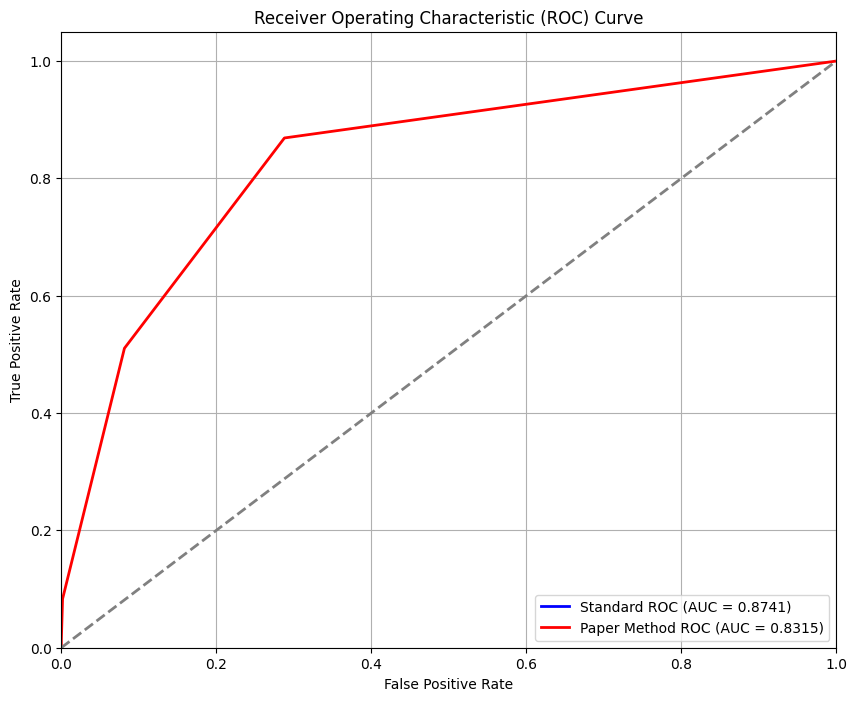

Evaluation complete. Results saved to /content/drive/MyDrive/DVSTraining/results


In [50]:
# After training is complete, calculate AUC and plot ROC curve
def evaluate_model_auc(model, matched_dataset, batch_size=128):
    """
    Evaluate model AUC and plot ROC curve.
    """
    from sklearn.metrics import roc_curve, auc, roc_auc_score
    import matplotlib.pyplot as plt

    # Create evaluation dataset
    # Use all data for simplicity, or you could use just validation data
    eval_generator = ti_image_generator(
        dataset=matched_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=4
    )

    # Get predictions and true labels
    all_predictions = []
    all_labels = []

    for i in range(len(eval_generator)):
        X_batch, y_batch = eval_generator[i]
        predictions = model.predict(X_batch, verbose=0)
        all_predictions.extend(predictions.flatten())
        all_labels.extend(y_batch.flatten())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Calculate AUC
    auc_score = roc_auc_score(all_labels, all_predictions)
    print(f"AUC Score: {auc_score:.4f}")

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)

    # Calculate manual ROC curve using paper method
    tps = []
    fps = []
    for threshold in [0.1, 0.3, 0.5, 0.7, 0.9, 0.99]:
        y_pred_binary = (all_predictions > threshold).astype(int)
        cm = confusion_matrix(all_labels, y_pred_binary)

        if cm.shape == (2, 2):  # Perfect shape
            tn, fp, fn, tp = cm.ravel()
        else:  # Handle edge cases
            tn = cm[0, 0] if cm.shape[0] > 0 and cm.shape[1] > 0 else 0
            fp = cm[0, 1] if cm.shape[0] > 0 and cm.shape[1] > 1 else 0
            fn = cm[1, 0] if cm.shape[0] > 1 and cm.shape[1] > 0 else 0
            tp = cm[1, 1] if cm.shape[0] > 1 and cm.shape[1] > 1 else 0

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        tps.append(tpr)
        fps.append(fpr)

    # Add boundary points
    manual_fps = [0] + fps + [1]
    manual_tps = [0] + tps + [1]

    # Sort by FPR
    sorted_pairs = sorted(zip(manual_fps, manual_tps))
    manual_fps = [x for x, y in sorted_pairs]
    manual_tps = [y for x, y in sorted_pairs]

    # Calculate manual AUC
    manual_auc = auc(manual_fps, manual_tps)
    print(f"Manual AUC Score: {manual_auc:.4f}")

    # Plot ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Standard ROC (AUC = {auc_score:.4f})')
    plt.plot(manual_fps, manual_tps, color='red', lw=2, label=f'Paper Method ROC (AUC = {manual_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)

    # Save the plot
    roc_path = os.path.join(output_dir, "roc_curve.pdf")
    plt.savefig(roc_path)
    plt.show()

    return auc_score, manual_auc

# Don't forget to import the confusion_matrix
from sklearn.metrics import confusion_matrix

# Evaluate the trained model
print("Evaluating model and calculating AUC...")
auc_score, manual_auc = evaluate_model_auc(model, matched_dataset)

# Save AUC scores
with open(os.path.join(output_dir, "auc_scores.txt"), "w") as f:
    f.write(f"Standard AUC: {auc_score:.4f}\n")
    f.write(f"Manual AUC: {manual_auc:.4f}\n")

print(f"Evaluation complete. Results saved to {output_dir}")

In [55]:
# Save h52pb.py to your working directory
with open('h52pb.py', 'w') as f:
    f.write('''from keras.models import load_model
import tensorflow as tf
import os
import os.path as osp
from keras import backend as K

import sys
input_path = ''
weight_file = sys.argv[1]

output_graph_name = weight_file[:-3] + '.pb'

def h5_to_pb(h5_model,output_dir,model_name,out_prefix = "output_",log_tensorboard = True):
    if osp.exists(output_dir) == False:
        os.mkdir(output_dir)
    out_nodes = []
    for i in range(len(h5_model.outputs)):
        out_nodes.append(out_prefix + str(i + 1))
        tf.identity(h5_model.output[i],out_prefix + str(i + 1))
    sess = K.get_session()
    from tensorflow.python.framework import graph_util,graph_io
    init_graph = sess.graph.as_graph_def()
    main_graph = graph_util.convert_variables_to_constants(sess,init_graph,out_nodes)
    graph_io.write_graph(main_graph,output_dir,name = model_name,as_text = False)
    if log_tensorboard:
        from tensorflow.python.tools import import_pb_to_tensorboard
        import_pb_to_tensorboard.import_to_tensorboard(osp.join(output_dir,model_name),output_dir)

output_dir = osp.join(os.getcwd(),"trans_model")

h5_model = load_model(weight_file)
h5_to_pb(h5_model,output_dir = output_dir,model_name = output_graph_name)
print('model saved')''')

# Run the script with your model path
!python h52pb.py /content/drive/MyDrive/DVSTraining/results/mlpf_model_final.h5

2025-05-14 04:34:44.274825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197284.295683  168091 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197284.302305  168091 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:34:47.978135: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1747197287.978285  168091 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16664 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9

In [57]:
!python h52pb.py /content/drive/MyDrive/DVSTraining/results/mlpf_model_final.h5

2025-05-14 04:44:54.121843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747197894.141534  170820 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747197894.147578  170820 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-14 04:44:58.043719: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1747197898.043865  170820 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 16664 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:00:03.0, compute capability: 8.9